In [1]:
# import module
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime
from pandas import Series,DataFrame
from math import *
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
import statsmodels.formula.api as sm
import time
import random
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgunbd.ttf').get_name()
mpl.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

## sklearn
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor)
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

#LightGBM
from lightgbm import LGBMClassifier, LGBMRegressor


# xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

# randomforest
from sklearn.ensemble import RandomForestClassifier

# MLP
from sklearn.neural_network import MLPClassifier



# Load Sihwa Data (2017.11.01~2019.06.30)

In [2]:
df = pd.read_csv('D:/data/row_sihwa.csv',encoding='CP949')

In [3]:
# preprocessing
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df[['site', 'date', 'so2', 'co', 'o3', 'no2', 'pm10', 'pm25', 'weather',
       'wind_speed', 'wind_direction', 'rain_yn', 'humid']]
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
df.loc[df['weather'] <= -30, 'weather' ] = np.float("nan")
df.isnull().sum()

site                 0
date                 0
so2                566
co                 487
o3                 448
no2                439
pm10               672
pm25              8002
weather            403
wind_speed         351
wind_direction     351
rain_yn            384
humid              333
dtype: int64

In [4]:
## 파생변수 ymd, md, month, season ,weekday 추가
def date_split(df) :
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
    df['ymd'] = [d.date() for d in df['date']]
    df['month'] = [d.month for d in df['date']]
    df['time'] = [d.time() for d in df['date']]
    df['time'] = df['time'].apply(lambda x: x.strftime('%H'))
    df['md'] = df['ymd'].apply(lambda x: x.strftime('%m-%d'))
    df['weekday'] =df['date'].apply(lambda x: x.strftime('%A'))
def season(x):
    if '05-31'>= x>='03-01':
        return('봄')
    elif '11-30' >= x >= '09-01':
        return('가을')
    elif '08-31' >=x >= '06-01':
        return('여름')
    else: return('겨울')


In [17]:
# modeling Definition
def average_modeling(models) :
    for i,m in enumerate(models):
        print(i, m.__class__)
        m.fit(x_train, y_train)

    models = sorted(models, key=lambda m: mean_squared_error(y_test, m.predict(x_test)))


    y_preds = np.array([m.predict(x_test) for m in models]).T
    y_preds_mean = y_preds.mean(axis=1)
    df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds_mean})
    print("RMSE : {:.3f}".format((mean_squared_error(y_test, y_preds_mean))**0.5))

    y_pred_log = np.array([m.predict(x_test) for m in models]).T.dot(
    np.linspace(1.0, 0.0, len(models))/sum(np.linspace(1.0, 0.0, len(models))))
    df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_log})
    print("RMSE : {:.3f}".format((mean_squared_error(y_test, y_pred_log))**0.5))

In [6]:
date_split(df)
df = df.dropna()
df['season'] = df['md'].apply(season)
df = df[df['site']=='시화산단']
# df['PM_categorical'] = df['pm25'].apply(categorical_PM)

In [7]:
# backup 
test= df.copy()
test2 = df.copy()
#data drop
df.drop(['date','site','md','ymd'],axis=1,inplace=True)
df = df.reset_index(drop=True)

## time, weekday 변수 추가

In [8]:
#weekday 포함
data = df.copy()
random.seed(100)

## x, y setting
X = data.drop(["pm25",'pm10','time'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season","weekday"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [9]:
# Xgboost
model = XGBRegressor(objective='reg:squarederror',random_state =5)

# model.fit(x_train, y_train, sample_weight = class_weights)
model.fit(x_train, y_train)

## Prediction
y_pred = model.predict(x_test)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 확인
print("RMSE : ",(mean_squared_error(y_test, y_pred))**0.5)
# df_predict.to_csv('D:/data/xgb_predict.csv',encoding='CP949')

RMSE :  12.647916107667129


In [10]:
# time weekday all add
data = df.copy()
random.seed(100)

## x, y setting
X = data.drop(["pm25",'pm10'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season","weekday",'time']:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [11]:
# Xgboost
model = XGBRegressor(objective='reg:squarederror',random_state =5)

# model.fit(x_train, y_train, sample_weight = class_weights)
model.fit(x_train, y_train)

## Prediction
y_pred = model.predict(x_test)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 확인
print("RMSE : ",(mean_squared_error(y_test, y_pred))**0.5)
# df_predict.to_csv('D:/data/xgb_predict.csv',encoding='CP949')

RMSE :  12.628342874724686


In [12]:
#time 포함
data = df.copy()
random.seed(100)

## x, y setting
X = data.drop(["pm25",'pm10','weekday'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season","time"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [13]:
# Xgboost
model = XGBRegressor(objective='reg:squarederror',random_state =5)

# model.fit(x_train, y_train, sample_weight = class_weights)
model.fit(x_train, y_train)

## Prediction
y_pred = model.predict(x_test)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 확인
print("RMSE : ",(mean_squared_error(y_test, y_pred))**0.5)
# df_predict.to_csv('D:/data/xgb_predict.csv',encoding='CP949')

RMSE :  12.593761985979421


Text(0, 0.5, '실제값')

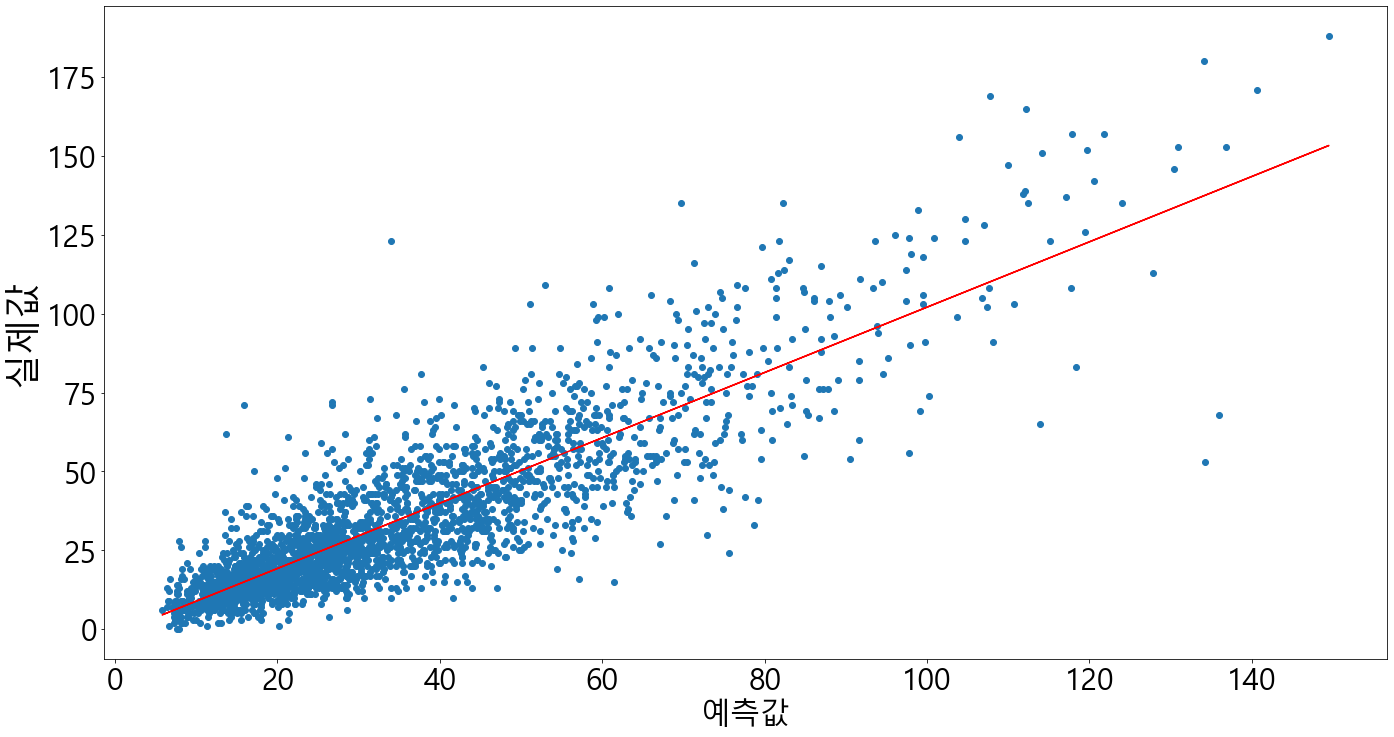

In [14]:
fit = np.polyfit(df_predict['Predicted'], df_predict['Actual'],1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(23,12))
plt.plot(df_predict['Predicted'], df_predict['Actual'],'o')
plt.plot(df_predict['Predicted'], fit_fn(df_predict['Predicted']), 'r')
plt.tick_params(labelsize=30)
plt.xlabel('예측값',size=30)
plt.ylabel('실제값',size=36)

In [15]:
max_depth = [1, 2, 4, 6, 8, 10, 12, 15]
for depth in max_depth:
    model = XGBRegressor(max_depth= depth, n_jobs=-1, objective='reg:squarederror',random_state =5)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("max_depth : ", depth,'\n' ,"테스트 RMSE : {:.3f}".format((mean_squared_error(y_test, y_pred))**0.5))

max_depth :  1 
 테스트 RMSE : 15.755
max_depth :  2 
 테스트 RMSE : 13.617
max_depth :  4 
 테스트 RMSE : 12.109
max_depth :  6 
 테스트 RMSE : 11.683
max_depth :  8 
 테스트 RMSE : 11.424
max_depth :  10 
 테스트 RMSE : 11.671
max_depth :  12 
 테스트 RMSE : 11.816
max_depth :  15 
 테스트 RMSE : 12.070


In [16]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200,500,1000]
for estimator in n_estimators:
    model = XGBRegressor(n_estimators=estimator, n_jobs=-1, objective='reg:squarederror',random_state =5)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("n_estimators : ", estimator,'\n' "RMSE : ", (mean_squared_error(y_test, y_pred))**0.5)

n_estimators :  1 
RMSE :  38.58819038660614
n_estimators :  2 
RMSE :  35.50199744860875
n_estimators :  4 
RMSE :  30.381343289682526
n_estimators :  8 
RMSE :  23.386227372216208
n_estimators :  16 
RMSE :  17.02702416195843
n_estimators :  32 
RMSE :  14.087336227029331
n_estimators :  64 
RMSE :  12.989108794362537
n_estimators :  100 
RMSE :  12.593761985979421
n_estimators :  200 
RMSE :  12.163362518027075
n_estimators :  500 
RMSE :  11.795105052482295
n_estimators :  1000 
RMSE :  11.715242538389841


In [17]:
# 저녁에 돌려보기 (11월 19일)
# param = {'max_depth': [4,6,8,10,12,15],
#          'subsample': [0.6, 0.8, 1.0],
#          'min_child_weight' : list(np.linspace(1, 1.5, 10))
# }
# # Xgboost
# model = XGBRegressor(objective='reg:squarederror', random_state=5)

# xgb_model = GridSearchCV(model, param_grid = param, cv = 3)
# xgb_model.fit(x_train, y_train)

# print("GridSearchCV 최적의 파라미터 : ", xgb_model.best_params_)
# print("GridSearchCV 최고 정확도 : ", xgb_model.best_score_)

# best_model = xgb_model.best_estimator_

# pred = best_model.predict(x_test)
# print("RMSE : {0:.4f}".format((mean_squared_error(y_test, y_pred))**0.5))

GridSearchCV 최적의 파라미터 :  {'max_depth': 8, 'min_child_weight': 1.0555555555555556, 'subsample': 0.6}
GridSearchCV 최고 정확도 :  0.7819619618628754
RMSE : 11.7152


In [18]:
# xgb gridsearch
# param = {'max_depth': [6, 8, 10, 12, 15],
#          'n_estimator' : [50, 100, 200, 500, 1000, 2000],
#          'min_child_weight' : list(np.linspace(1, 2, 10)),
#          'subsample' : list(np.linspace(0, 1, 5))
# }
# # Xgboost
# model = XGBRegressor(objective='reg:squarederror',random_state =5)

# xgb_model = GridSearchCV(model, param_grid = param, cv = 3)
# xgb_model.fit(x_train, y_train)

# print("GridSearchCV 최적의 파라미터 : ", xgb_model.best_params_)
# print("GridSearchCV 최고 정확도 : ", xgb_model.best_score_)

# best_model = xgb_model.best_estimator_

# y_pred = best_model.predict(x_test)
# print("RMSE : {0:.4f}".format((mean_squared_error(y_test, y_pred))**0.5)) 

GridSearchCV 최적의 파라미터 :  {'max_depth': 6, 'min_child_weight': 1.1111111111111112, 'n_estimator': 50, 'subsample': 0.75}
GridSearchCV 최고 정확도 :  0.7820802550920694
RMSE : 11.6398


In [19]:
# lasso gridsearch
lasso_param = {'alpha' : list(np.linspace(0.0001, 0.9, 50))}
# lasso
model = Lasso()

lasso_model = GridSearchCV(model, param_grid = lasso_param, cv = 5)
lasso_model.fit(x_train, y_train)

print("GridSearchCV 최적의 파라미터 : ", lasso_model.best_params_)
print("GridSearchCV 최고 정확도 : ", lasso_model.best_score_)

best_model = lasso_model.best_estimator_

y_pred = best_model.predict(x_test)
print("RMSE : {0:.4f}".format((mean_squared_error(y_test, y_pred))**0.5))

GridSearchCV 최적의 파라미터 :  {'alpha': 0.0001}
GridSearchCV 최고 정확도 :  0.5833661202074596
RMSE : 16.5027


In [20]:
# Ridge gridsearch
ridge_param = {'alpha' : list(np.linspace(0.0001, 1, 100))}
# lasso
model = Ridge()

ridge_model = GridSearchCV(model, param_grid = lasso_param, cv = 5)
ridge_model.fit(x_train, y_train)

print("GridSearchCV 최적의 파라미터 : ", ridge_model.best_params_)
print("GridSearchCV 최고 정확도 : ", ridge_model.best_score_)

best_model = lasso_model.best_estimator_

y_pred = best_model.predict(x_test)
print("RMSE : {0:.4f}".format((mean_squared_error(y_test, y_pred))**0.5))

GridSearchCV 최적의 파라미터 :  {'alpha': 0.0001}
GridSearchCV 최고 정확도 :  0.5833664568947498
RMSE : 16.5027


In [42]:
# Random Search CV (xgb)
param = {'max_depth': list(range(4, 25)),
         'n_estimator' : list(range(10, 2000, 30)),
         'min_child_weight' : list(np.linspace(1, 10, 15)),
         'subsample' : list(np.linspace(0, 1, 7))
}
# Xgboost
model = XGBRegressor(objective='reg:squarederror',random_state =5)

xgb_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 3)
xgb_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", xgb_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", xgb_model.best_score_)

best_model = xgb_model.best_estimator_

y_pred = best_model.predict(x_test)
print("RMSE : {0:.4f}".format((mean_squared_error(y_test, y_pred))**0.5)) 

RandomizedSearchCV 최적의 파라미터 :  {'subsample': 0.8333333333333333, 'n_estimator': 340, 'min_child_weight': 2.928571428571429, 'max_depth': 9}
RandomizedSearchCV 최고 RMSE :  0.7825921448138624
RMSE : 11.3229


In [45]:
# Random Search CV (xgb)
param = {'max_depth': list(range(4, 25)),
         'learning_rate' : list(np.linspace(0, 1, 30)),
         'n_estimator' : list(range(10, 2000, 30)),
         'min_child_weight' : list(np.linspace(1, 10, 15)),
         'subsample' : list(np.linspace(0, 1, 7))
}
# Xgboost
model = XGBRegressor(objective='reg:squarederror',random_state =5)

xgb_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 3)
xgb_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", xgb_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", xgb_model.best_score_)

best_model = xgb_model.best_estimator_

y_pred = best_model.predict(x_test)
print("RMSE : {0:.4f}".format((mean_squared_error(y_test, y_pred))**0.5)) 

RandomizedSearchCV 최적의 파라미터 :  {'subsample': 0.5, 'n_estimator': 940, 'min_child_weight': 5.5, 'max_depth': 10, 'learning_rate': 0.06896551724137931}
RandomizedSearchCV 최고 정확도 :  0.7820066586126643
RMSE : 11.2622


In [48]:
# Random Search CV (lgbm)
param = {'max_depth': list(range(4, 25)),
         'learning_rate' : list(np.linspace(0, 1, 30)),
         'n_estimator' : list(range(10, 2000, 30)),
         'num_leaves' : list(range(5, 100)),
         'bagging_fraction' : list(np.linspace(0.1,1,20))
}
# LightGBM
model = LGBMRegressor(random_state =5)
lgbm_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 3)
lgbm_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", lgbm_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", lgbm_model.best_score_)

best_model = lgbm_model.best_estimator_

y_pred = best_model.predict(x_test)
print("RMSE : {0:.4f}".format((mean_squared_error(y_test, y_pred))**0.5)) 

RandomizedSearchCV 최적의 파라미터 :  {'num_leaves': 69, 'n_estimator': 910, 'max_depth': 9, 'learning_rate': 0.06896551724137931, 'bagging_fraction': 0.8578947368421053}
RandomizedSearchCV 최고 정확도 :  0.7786388242286454
RMSE : 11.5258


In [ ]:
param_list = {"n_estimators": list(range(10, 100, 10)),
              "max_depth": [4, 8, 12, 16],
              "max_features": [3, 5, 7, 9],
              "min_samples_split": [3, 5, 7, 9]}

rf_model = RandomForestClassifier(random_state = 777)

rf_random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions = param_list,
        n_iter = 10,
        cv = 5,
        scoring = make_scorer(accuracy_score))

rf_random_search.fit(X_train, y_train)

# Average Ensemble

### Row average Ensemble

In [ ]:
# compare row model & self tunning model
data = df.copy()
random.seed(100)
## x, y setting
X = data.drop(["pm25",'pm10','weekday'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "time"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [21]:
model = RandomForestRegressor(random_state =5)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 확인
print("RMSE : ", (mean_squared_error(y_test, y_pred))**0.5)

RMSE :  12.558366159897577


In [25]:
models = [RandomForestRegressor(random_state =5) ]

average_modeling(models)


0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
RMSE : 12.558
RMSE : 12.558


In [23]:
y_preds_mean

array([56.8, 75. , 55.7, ..., 33.6, 17.7, 45.2])

In [24]:
models = [RandomForestRegressor(random_state =5) ]
models +=[Lasso(random_state =5)]
models +=[KernelRidge()]
models +=[GradientBoostingRegressor(random_state =5)]
models +=[XGBRegressor(objective='reg:squarederror',random_state =5)]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.linear_model.coordinate_descent.Lasso'>
2 <class 'sklearn.kernel_ridge.KernelRidge'>
3 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
4 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 13.457
RMSE : 12.294


In [23]:
models = [RandomForestRegressor(random_state =5) ]
models +=[Lasso(random_state =5)]
models +=[KernelRidge()]
models += [SVR(kernel='rbf', C=1.0, epsilon=0.05)]
models +=[GradientBoostingRegressor(random_state =5)]
models +=[XGBRegressor(objective='reg:squarederror',random_state =5)]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.linear_model.coordinate_descent.Lasso'>
2 <class 'sklearn.kernel_ridge.KernelRidge'>
3 <class 'sklearn.svm.classes.SVR'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 14.420
RMSE : 12.574


In [22]:
#del lasso kernel ridge

models = [RandomForestRegressor(random_state =5) ]
models +=[GradientBoostingRegressor(random_state =5)]
models +=[XGBRegressor(objective='reg:squarederror',random_state =5)]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 12.176
RMSE : 12.162


In [21]:
# ridge elasticnet add
models = []
models += [RandomForestRegressor(random_state =5)]
models += [Ridge(random_state=5)]
models +=[ElasticNet(random_state =5)]
models +=[GradientBoostingRegressor(random_state =5)]
models +=[XGBRegressor(objective='reg:squarederror',random_state =5)]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.linear_model.ridge.Ridge'>
2 <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
3 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
4 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 13.648
RMSE : 12.267


In [30]:
# hyper parameter tunning
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models +=[XGBRegressor(n_estimators=n, objective='reg:squarederror',random_state =5) for n in [50, 100, 200, 500]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'xgboost.sklearn.XGBRegressor'>
6 <class 'xgboost.sklearn.XGBRegressor'>
7 <class 'xgboost.sklearn.XGBRegressor'>
8 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 11.857
RMSE : 11.651


In [20]:
# hyper parameter tunning
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models +=[XGBRegressor(max_depth= 8,
                       objective='reg:squarederror',
                       min_child_weight=1.111, n_estimator= n, subsample=0.6, random_state =5) for n in [30,50,100,200,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'xgboost.sklearn.XGBRegressor'>
6 <class 'xgboost.sklearn.XGBRegressor'>
7 <class 'xgboost.sklearn.XGBRegressor'>
8 <class 'xgboost.sklearn.XGBRegressor'>
9 <class 'xgboost.sklearn.XGBRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 11.382
RMSE : 11.342


In [19]:
# hyper parameter tunning
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(3,5)]
models +=[XGBRegressor(max_depth= 8,
                       objective='reg:squarederror',
                       min_child_weight=1.111, n_estimator= n, subsample=0.6, random_state =5) for n in [30,50,100,200,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'xgboost.sklearn.XGBRegressor'>
8 <class 'xgboost.sklearn.XGBRegressor'>
9 <class 'xgboost.sklearn.XGBRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
11 <class 'xgboost.sklearn.XGBRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 11.312
RMSE : 11.331


In [18]:
# hyper parameter tunning
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models+=[LassoLarsCV()]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(3,5)]
models +=[XGBRegressor(max_depth= 8,
                       objective='reg:squarederror',
                       min_child_weight=1.111, n_estimator= n, subsample=0.75, random_state =5) for n in [30,50,100,200,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'sklearn.linear_model.least_angle.LassoLarsCV'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'sklearn.kernel_ridge.KernelRidge'>
8 <class 'xgboost.sklearn.XGBRegressor'>
9 <class 'xgboost.sklearn.XGBRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
11 <class 'xgboost.sklearn.XGBRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
13 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 11.400
RMSE : 11.291


In [26]:
# model tunning add
models = [RandomForestRegressor(n_estimators=n,random_state =5) for n in [30, 50, 100, 200]]
models += [Ridge(alpha=0.05,random_state =5)]
models +=[Lasso(alpha =0.3,random_state =5)]
models +=[ElasticNet(alpha=n ,random_state =5) for n in [0.005,0.05,0.03]]
models +=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(2,5)]
models +=[GradientBoostingRegressor()]
models +=[XGBRegressor(objective='reg:squarederror', max_depth=10, min_child_weight=1.388, subsample=0.6,random_state =5)]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.linear_model.ridge.Ridge'>
5 <class 'sklearn.linear_model.coordinate_descent.Lasso'>
6 <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
7 <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
8 <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
9 <class 'sklearn.kernel_ridge.KernelRidge'>
10 <class 'sklearn.kernel_ridge.KernelRidge'>
11 <class 'sklearn.kernel_ridge.KernelRidge'>
12 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
13 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 12.877
RMSE : 11.751


In [27]:
# hyper parameter tunning
models = [RandomForestRegressor(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[LassoLarsCV()]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(2,5)]
models+=[GradientBoostingRegressor(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5) for n_e in [3000, 5000]]
models+=[XGBRegressor(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.linear_model.least_angle.LassoLarsCV'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'sklearn.kernel_ridge.KernelRidge'>
8 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
9 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
[10:40:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
11 <class 'xgboost.sklearn.XGBRegressor'>
[10:40:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
12 <class 'xgboost.sklearn.XGBRegressor'>
[10:40:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [28]:
# hyper parameter tunning
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models+=[LassoLarsCV()]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(3,5)]
models +=[XGBRegressor(max_depth= 8,
                       objective='reg:squarederror',
                       min_child_weight=1.111, n_estimator= n, subsample=0.75, random_state =5) for n in [30,50,100,200,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'sklearn.linear_model.least_angle.LassoLarsCV'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'sklearn.kernel_ridge.KernelRidge'>
8 <class 'xgboost.sklearn.XGBRegressor'>
9 <class 'xgboost.sklearn.XGBRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
11 <class 'xgboost.sklearn.XGBRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
13 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 11.400
RMSE : 11.291


In [29]:
# add lightGBM
models = [RandomForestRegressor(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[LassoLarsCV()]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(2,5)]
models+=[GradientBoostingRegressor(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=15, max_features='sqrt',objective='reg:squarederror',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [500,1000,3000, 5000]]
models+=[XGBRegressor(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMRegressor( n_estimators=n,colsample_bytree=0.9497036, subsample=0.8715623, max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775, random_state=5)for n in [50,100,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.linear_model.least_angle.LassoLarsCV'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'sklearn.kernel_ridge.KernelRidge'>
8 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
9 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
10 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
11 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
[10:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
13 <class 'xgboost.sklearn.XGBRegressor'>
[10:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now depreca

In [30]:
# add lightGBM
models = [RandomForestRegressor(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[LassoLarsCV()]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(2,5)]
models+=[GradientBoostingRegressor(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',objective='reg:squarederror',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5) for n_e in [3000, 5000]]
models+=[XGBRegressor(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMRegressor( n_estimators=n, max_depth=8, random_state=5)for n in [50,100,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.linear_model.least_angle.LassoLarsCV'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'sklearn.kernel_ridge.KernelRidge'>
8 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
9 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
[11:05:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
11 <class 'xgboost.sklearn.XGBRegressor'>
[11:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
12 <class 'xgboost.sklearn.XGBRegressor'>
[11:05:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [31]:
# add lightGBM
models = [RandomForestRegressor(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[LassoLarsCV()]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(2,5)]
models+=[GradientBoostingRegressor(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBRegressor(max_depth= 10, objective='reg:squarederror', min_child_weight=1.111, 
                      n_estimator= n, subsample=0.75, random_state =5) for n in [50, 100,200,400]]
models += [LGBMRegressor( n_estimators=n, max_depth=8, random_state=5)for n in [50,100,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.linear_model.least_angle.LassoLarsCV'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'sklearn.kernel_ridge.KernelRidge'>
8 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
9 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
11 <class 'xgboost.sklearn.XGBRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
13 <class 'xgboost.sklearn.XGBRegressor'>
14 <class 'lightgbm.sklearn.LGBMRegressor'>
15 <class 'lightgbm.sklearn.LGBMRegressor'>
16 <class 'lightgbm.sklearn.LGBMRegressor'>
17 <class 'lightgbm.sklearn.LGBMRegressor'>
RMSE : 11.244
RMSE : 11.089


# RF(Classifier, Regressor)

In [40]:
# randomforest
data = df.copy()
random.seed(100)
## x, y setting
X = data.drop(["pm25",'pm10','weekday'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "time"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model = RandomForestClassifier(random_state =5)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 확인
print("RMSE : ", (mean_squared_error(y_test, y_pred))**0.5)

RMSE :  18.675731700403457


Text(0, 0.5, '실제값')

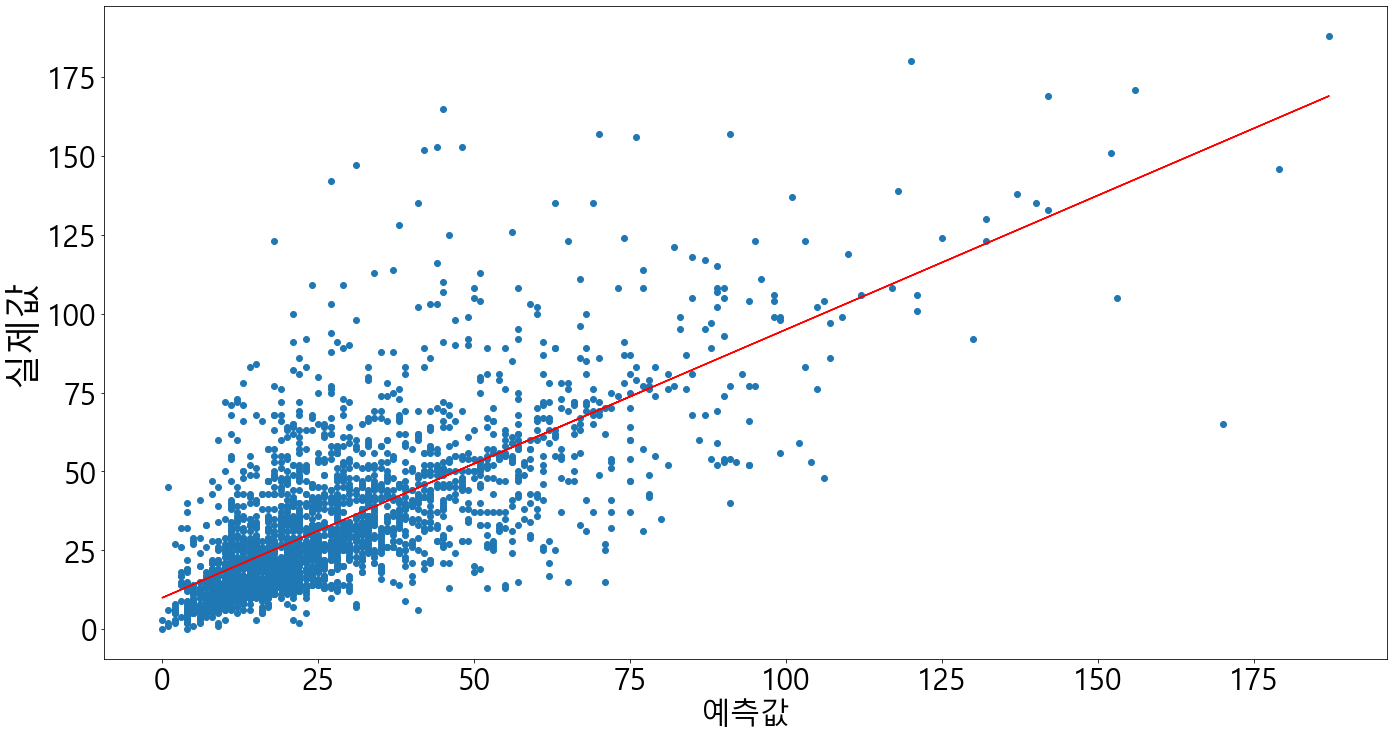

In [41]:
fit = np.polyfit(df_predict['Predicted'], df_predict['Actual'],1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(23,12))
plt.plot(df_predict['Predicted'], df_predict['Actual'],'o')
plt.plot(df_predict['Predicted'], fit_fn(df_predict['Predicted']), 'r')
plt.tick_params(labelsize=30)
plt.xlabel('예측값',size=30)
plt.ylabel('실제값',size=36)

In [42]:
# randomforest tuning
data = df.copy()
random.seed(100)
## x, y setting
X = data.drop(["pm25",'pm10'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "weekday"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
model = RandomForestClassifier(max_depth= 15,
                               max_features= 'auto',
                               n_estimators= 1000,
                               n_jobs= 1)
# model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=model.classes_)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 확인
print("RMSE : ", (mean_squared_error(y_test, y_pred))**0.5)

RMSE :  13.234968603642168


# LR

In [45]:
# Linear Regression
data = df.copy()
random.seed(100)
## x, y setting
X = data.drop(["pm25",'pm10'], axis=1)
Y = data["pm25"]
regressor = LinearRegression()  
regressor.fit(x_train, y_train)

print(regressor.intercept_)
# For retrieving the slope:

print(regressor.coef_)
y_pred=regressor.predict(x_test)  
print("RMSE : ", (mean_squared_error(y_test, y_pred))**0.5)

df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


-31.011628488943558
[ 1.26811134e+02  5.94507335e+01  3.66794196e+02  5.04193804e+02
  2.59739862e-02 -2.93187760e-01  2.44399728e-02 -3.54597269e-01
  1.31942883e-01 -5.46077585e-01 -2.12370390e-01 -1.41923352e+00
 -3.46628084e+00]
RMSE :  16.465048263121783


In [46]:
result = sm.ols(formula = 'pm25~so2+co+o3+no2+wind_speed+wind_direction+rain_yn+humid+month+season', data = df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pm25   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     1590.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:09:47   Log-Likelihood:                -55716.
No. Observations:               13196   AIC:                         1.115e+05
Df Residuals:                   13183   BIC:                         1.116e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -36.0403      1.179    -30.575      0.000     -38.351     -33.730
season[T.겨울]       3.0083      0.525      5.730      0.000       1.979       4.037
season[T.봄]        8.5083      0.554     15.366      0.000       7.423       9.594
season[T.여름]       1.9457      0.523      3.722      0.000       0.921       2.970
so2              114.9536     14.225      8.081      0.000      87.071     142.836
co                62.6720      1.062     59.001      0.000      60.590      64.754
o3               299.8826     11.007     27.245      0.000     278.307     321.458
no2              404.9199     16.973     23.857      0.000     371.651     438.189
wind_speed        -0.4430      0.124     -3.582      0.000      -0.685      -0.201
wind_direction     0.0237      0.001     15.930      0.000       0.021       0.027
rain_yn           -0.3901      0.093     -4.178      0.000      -0.573      -0.207
humid              0.1324      0.009     14.439      0.000       0.114       0.150
month             -0.3170      0.053     -6.028      0.000      -0.420      -0.214
==============================================================================
Omnibus:                     2576.106   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11293.512
Skew:                           0.897   Prob(JB):                         0.00
Kurtosis:                       7.162   Cond. No.                     2.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, '실제값')

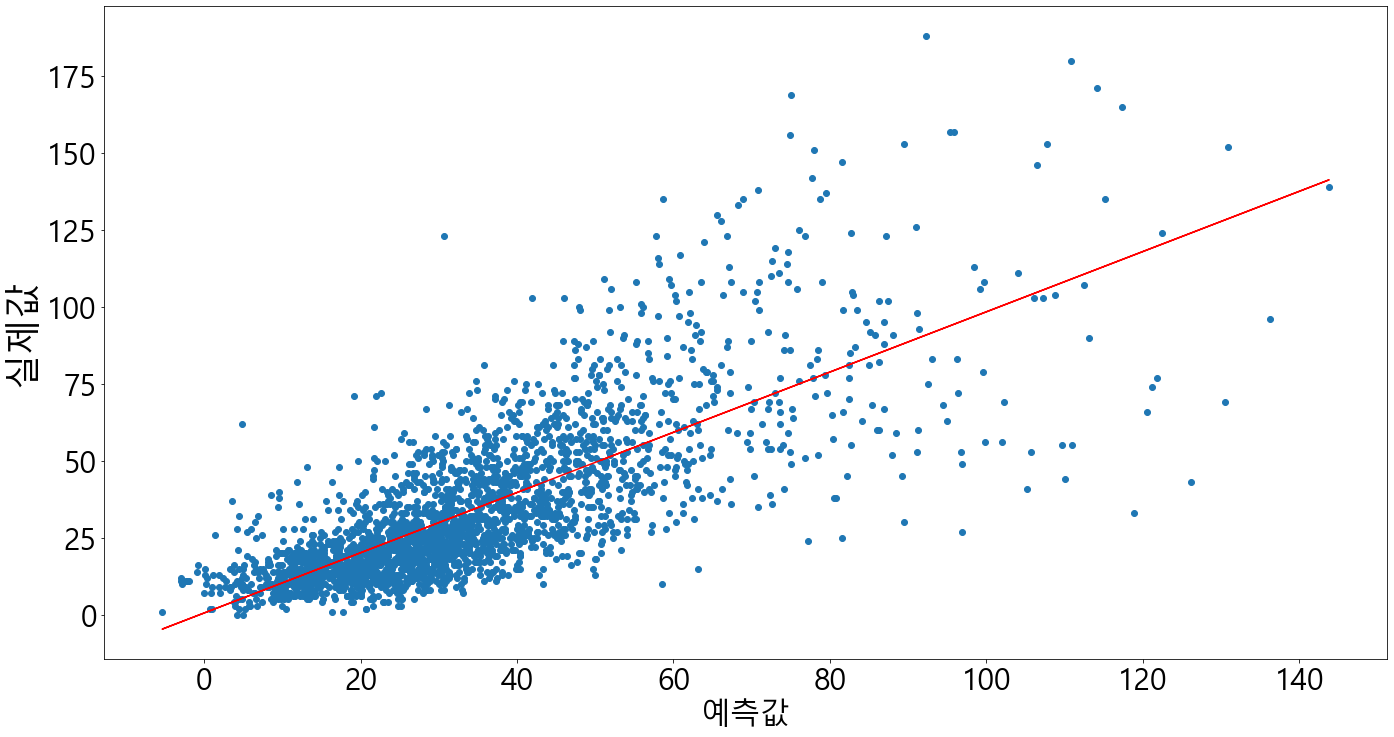

In [47]:
fit = np.polyfit(df_predict['Predicted'], df_predict['Actual'],1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(23,12))
plt.plot(df_predict['Predicted'], df_predict['Actual'],'o')
plt.plot(df_predict['Predicted'], fit_fn(df_predict['Predicted']), 'r')
plt.tick_params(labelsize=30)
plt.xlabel('예측값',size=30)
plt.ylabel('실제값',size=36)

In [48]:
df.head()

,so2,co,o3,no2,pm10,pm25,weather,wind_speed,wind_direction,rain_yn,humid,month,time,weekday,season
0,0.110,0.5,0.039,0.017,34.0,18.0,8.5,0.0,0.0,0.0,88.0,11,00,Wednesday,가을
1,0.024,0.5,0.024,0.025,47.0,31.0,10.5,1.0,192.1,0.0,85.7,11,01,Wednesday,가을
2,0.012,0.5,0.014,0.032,54.0,38.0,11.1,1.9,208.6,0.0,80.7,11,02,Wednesday,가을
3,0.008,0.5,0.014,0.030,65.0,51.0,11.1,1.6,210.8,0.0,80.4,11,03,Wednesday,가을
4,0.015,0.5,0.028,0.032,48.0,49.0,17.6,2.4,218.8,0.0,65.6,11,12,Wednesday,가을


In [49]:
test = test.drop(['date','md','time','site'],axis=1).reset_index(drop=True)
test_list = test['ymd'].unique().tolist()
for dummy in ["season", "weekday"]:
    test[dummy] = pd.get_dummies(test[dummy])
df_rmse = pd.DataFrame()
for i in range(len(test_list)):
    if i == len(test_list)-2:
        break
    else :
        train = test[test['ymd']==test_list[i]]
        testing = test[test['ymd']==test_list[i+1]]
        train.drop(['ymd'],axis=1,inplace=True)
        testing.drop(['ymd'],axis=1,inplace=True)
        x_train = train.drop(["pm25"], axis=1)
        y_train = train['pm25']
        x_test = testing.drop(["pm25"], axis=1)
        y_test = testing['pm25']
        # Xgboost
        model = XGBRegressor(objective='reg:squarederror',random_state =5)

        # model.fit(x_train, y_train, sample_weight = class_weights)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        df_rmse = pd.concat([df_rmse,df_predict])
print("RMSE : ",(mean_squared_error(df_rmse['Actual'], df_rmse['Predicted']))**0.5)

RMSE :  17.136673491620172


In [50]:
test_list = test['ymd'].unique().tolist()
for dummy in ["season", "weekday"]:
    test[dummy] = pd.get_dummies(test[dummy])
df_rmse = pd.DataFrame()
for i in range(len(test_list)):
    if i == len(test_list)-2:
        break
    else :
        train = test[test['ymd']==test_list[i]]
        testing = test[test['ymd']==test_list[i+1]]
        train.drop(['ymd'],axis=1,inplace=True)
        testing.drop(['ymd'],axis=1,inplace=True)
        x_train = train.drop(["pm25"], axis=1)
        y_train = train['pm25']
        x_test = testing.drop(["pm25"], axis=1)
        y_test = testing['pm25']
        # Xgboost
        model = RandomForestRegressor(random_state =5)

        # model.fit(x_train, y_train, sample_weight = class_weights)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        df_rmse = pd.concat([df_rmse,df_predict])
print("RMSE : ",(mean_squared_error(df_rmse['Actual'], df_rmse['Predicted']))**0.5)

RMSE :  17.0607652845231


In [51]:
test2.head()

,site,date,so2,co,o3,no2,pm10,pm25,weather,wind_speed,wind_direction,rain_yn,humid,ymd,month,time,md,weekday,season
7296,시화산단,2017-11-01 00:00:00,0.110,0.5,0.039,0.017,34.0,18.0,8.5,0.0,0.0,0.0,88.0,2017-11-01,11,00,11-01,Wednesday,가을
7297,시화산단,2017-11-01 01:00:00,0.024,0.5,0.024,0.025,47.0,31.0,10.5,1.0,192.1,0.0,85.7,2017-11-01,11,01,11-01,Wednesday,가을
7298,시화산단,2017-11-01 02:00:00,0.012,0.5,0.014,0.032,54.0,38.0,11.1,1.9,208.6,0.0,80.7,2017-11-01,11,02,11-01,Wednesday,가을
7299,시화산단,2017-11-01 03:00:00,0.008,0.5,0.014,0.030,65.0,51.0,11.1,1.6,210.8,0.0,80.4,2017-11-01,11,03,11-01,Wednesday,가을
7308,시화산단,2017-11-01 12:00:00,0.015,0.5,0.028,0.032,48.0,49.0,17.6,2.4,218.8,0.0,65.6,2017-11-01,11,12,11-01,Wednesday,가을


In [52]:
# year, month 구하기
# 위의 식과 동일하지만 조건문으로 
test2['date'] = test2['date'].astype(str)
test2['ym'] = test2['date'].str[:7]
test2.drop(['date','site','ymd','md','time'],axis=1,inplace=True)

for dummy in ["season", "weekday"]:
    test2[dummy] = pd.get_dummies(test2[dummy])

test_ym = test2['ym'].unique().tolist()

month_rmse = pd.DataFrame()
for i in range(len(test_ym)):
    if i == len(test_ym)-2:
        break

    else :
        train = test2[test2['ym']==test_ym[i]]
        testing = test2[test2['ym']==test_ym[i+1]]
        train.drop(['ym'],axis=1,inplace=True)
        testing.drop(['ym'],axis=1,inplace=True)

        x_train = train.drop(["pm25"], axis=1)
        y_train = train['pm25']
        x_test = testing.drop(["pm25"], axis=1)
        y_test = testing['pm25']
        # Xgboost
        model = XGBRegressor(objective='reg:squarederror',random_state =5)

        # model.fit(x_train, y_train, sample_weight = class_weights)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        month_rmse = pd.concat([month_rmse,df_predict])
print("RMSE : ",(mean_squared_error(month_rmse['Actual'], month_rmse['Predicted']))**0.5)

RMSE :  13.092644648015058


In [53]:
# year, month 구하기
# 위의 식과 동일하지만 조건문으로 

for dummy in ["season", "weekday"]:
    test2[dummy] = pd.get_dummies(test2[dummy])

test_ym = test2['ym'].unique().tolist()

month_rmse = pd.DataFrame()
for i in range(len(test_ym)):
    if i == len(test_ym)-2:
        break

    else :
        train = test2[test2['ym']==test_ym[i]]
        testing = test2[test2['ym']==test_ym[i+1]]
        train.drop(['ym'],axis=1,inplace=True)
        testing.drop(['ym'],axis=1,inplace=True)

        x_train = train.drop(["pm25"], axis=1)
        y_train = train['pm25']
        x_test = testing.drop(["pm25"], axis=1)
        y_test = testing['pm25']
        # Xgboost
        model = XGBRegressor(objective='reg:squarederror',random_state =5)

        # model.fit(x_train, y_train, sample_weight = class_weights)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        month_rmse = pd.concat([month_rmse,df_predict])
print("RMSE : ",(mean_squared_error(month_rmse['Actual'], month_rmse['Predicted']))**0.5)

RMSE :  13.092644648015058


# 범주형 모델링

In [32]:
df = pd.read_csv('D:/data/row_sihwa.csv',encoding='CP949')

In [33]:
# preprocessing
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df[['site', 'date', 'so2', 'co', 'o3', 'no2', 'pm10', 'pm25', 'weather',
       'wind_speed', 'wind_direction', 'rain_yn', 'humid']]
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
df.loc[df['weather'] <= -30, 'weather' ] = np.float("nan")
df.isnull().sum()

site                 0
date                 0
so2                566
co                 487
o3                 448
no2                439
pm10               672
pm25              8002
weather            403
wind_speed         351
wind_direction     351
rain_yn            384
humid              333
dtype: int64

In [34]:
## EDA 위한 파생변수 ymd, md, month, season ,weekday, pm categori 추가
def date_split(df) :
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
    df['ymd'] = [d.date() for d in df['date']]
    df['month'] = [d.month for d in df['date']]
    df['time'] = [d.time() for d in df['date']]
    df['time'] = df['time'].apply(lambda x: x.strftime('%H'))
    df['md'] = df['ymd'].apply(lambda x: x.strftime('%m-%d'))
    df['weekday'] =df['date'].apply(lambda x: x.strftime('%A'))
def season(x):
    if '05-31'>= x>='03-01':
        return('봄')
    elif '11-30' >= x >= '09-01':
        return('가을')
    elif '08-31' >=x >= '06-01':
        return('여름')
    else: return('겨울')

def categorical_PM(x):
    if 8>= x>=0:
        return('0')
    elif 15 >= x >= 9 :
        return('1')
    elif 20 >=x >= 16:
        return('2')
    elif 25 >=x >= 21:
        return('3')
    elif 37 >=x >= 26:
        return('4')
    elif 50 >=x >= 38:
        return('5')
    elif 75 >=x >= 51:
        return('6')
    else: return('7') 

In [35]:
# categorical modeling definition

def categorical_modeling(models):
    votingC = VotingClassifier(estimators=[(f'{m}' , m) for m in models], voting='hard')
 
    votingC = votingC.fit(x_train, y_train)

    #예측 진행
    y_pred = votingC.predict(x_test) 

    # ACC, F1-score check
    print("ACC : ", accuracy_score(y_test, y_pred))
    print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

In [36]:
date_split(df)
df = df.dropna()
df['season'] = df['md'].apply(season)
df['PM_categorical'] = df['pm25'].apply(categorical_PM)
# df['PM_categorical'] = df['PM_categorical'].astype('int')
df['PM_categorical'] = df['PM_categorical'].astype('category')

In [37]:
df = df[df['site']=='시화산단']
df.drop(['date','site','md','ymd'],axis=1,inplace=True)
df = df.reset_index(drop=True)

In [38]:
data = df.copy()
random.seed(100)

## x, y setting
X = data.drop(["pm25",'pm10','PM_categorical'], axis=1)
Y = data["PM_categorical"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "weekday",'time']:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

In [16]:
#mlp

model = MLPClassifier()
model.fit(x_train, y_train)

## Prediction
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=model.classes_)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

## check ACC, F1-score
print("ACC : ", accuracy_score(y_test, y_pred))
print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

ACC : 0.358
f1-score :  0.28395688108042444


In [60]:
# Xgboost 
model = XGBClassifier(objective ='multi:softprob', random_state= 5)

# model.fit(x_train, y_train, sample_weight = class_weights)
model.fit(x_train, y_train)

## Prediction
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=model.classes_)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 중요도 확인
importance = list(model.feature_importances_)
col_nm = list(X.columns)

## check ACC, F1-score
print("ACC : ", accuracy_score(y_test, y_pred))
print("f1-score : ", f1_score(y_test, y_pred, average='macro'))



ACC : 0.423
f1-score :  0.4005046919453577
                변수       중요도
1               co  0.306599
0              so2  0.148200
9            month  0.078902
3              no2  0.077103
4          weather  0.067093
12          season  0.057460
2               o3  0.057402
6   wind_direction  0.055460
8            humid  0.045062
11         weekday  0.038776
5       wind_speed  0.035248
10            time  0.017721
7          rain_yn  0.014975


In [61]:
# RandomForest
model = RandomForestClassifier(random_state= 5)

# model.fit(x_train, y_train, sample_weight = class_weights)
model.fit(x_train, y_train)

## Prediction
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=model.classes_)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## 중요도 확인
col_nm = list(X.columns)
# col_nm = list(x_train.columns)

## check ACC, F1-score
print("ACC : ", accuracy_score(y_test, y_pred))
print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

ACC :  0.43333333333333335
f1-score :  0.44724307881134717


In [62]:
# Logistic
model = LogisticRegression(random_state= 5)

# model.fit(x_train, y_train, sample_weight = class_weights)
model.fit(x_train, y_train)

## Prediction
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)
y_pred_prob_df = pd.DataFrame(y_pred_prob)

# each data predict
df_predict = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
## check importance
col_nm = list(X.columns)

## check ACC, F1-score
print("ACC : ", accuracy_score(y_test, y_pred))
print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

ACC :  0.325
f1-score :  0.24605022157254525


In [40]:
# average model voting

RFmodels = RandomForestClassifier(random_state =5) 
GBmodels =GradientBoostingClassifier(random_state =5)
XGBmodels =XGBClassifier(random_state =5)

categorical_modeling(models)

ACC :  0.46704545454545454
f1-score :  0.4695013230172903


In [39]:
# parameter tunning

models = [RandomForestClassifier(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingClassifier(random_state =5)]
models +=[XGBClassifier(max_depth= 8,
                       objective='multi:softprob',
                       min_child_weight=1.111, n_estimator= n, subsample=0.75, random_state =5) for n in [30,50,100,200,500,1000]]

categorical_modeling(models)

ACC :  0.46704545454545454
f1-score :  0.4695013230172903


In [41]:
# hyper parameter tunning\
models = []
models += [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
# models+=[LassoLarsCV()]
# models+=[KernelRidge(alpha=0.6, kernel='sigmoid', degree=i, coef0=2.5) for i in range(2,5)]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [1000, 2000]]
models+=[XGBClassifier(max_depth=10, objective='multi:softprob', n_estimators=n, subsample=0.75,random_state =5)
         for n in [50, 100,200,400]]


categorical_modeling(models)

ACC :  0.4799242424242424
f1-score :  0.48305245716619716


In [42]:
# hyper parameter tunning\
models = []
models += [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [1000, 2000]]
models+=[XGBClassifier(max_depth=10, objective='multi:softprob', n_estimators=n, subsample=0.75,random_state =5)
         for n in [50, 100,200,400]]

models += [LGBMClassifier( n_estimators=n,colsample_bytree=0.9497036, subsample=0.8715623, max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.4738636363636364
f1-score :  0.47565072301748135


In [43]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=10, random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.49015151515151517
f1-score :  0.49169295524120715


In [44]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.49015151515151517
f1-score :  0.4920023993305499


In [56]:
# Random Search CV (xgb)
param = {'max_depth': list(range(4, 25)),
         'learning_rate' : list(np.linspace(0, 1, 30)),
         'n_estimator' : list(range(10, 2000, 30)),
         'min_child_weight' : list(np.linspace(1, 10, 15)),
         'subsample' : list(np.linspace(0, 1, 7))
}
# Xgboost
model = XGBClassifier(objective='multi:softprob',random_state =5)

xgb_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 3)
xgb_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", xgb_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", xgb_model.best_score_)

best_model = xgb_model.best_estimator_

y_pred = best_model.predict(x_test)
print("ACC : ", accuracy_score(y_test, y_pred))

RandomizedSearchCV 최적의 파라미터 :  {'subsample': 0.3333333333333333, 'n_estimator': 1750, 'min_child_weight': 2.928571428571429, 'max_depth': 23, 'learning_rate': 0.06896551724137931}
RandomizedSearchCV 최고 정확도 :  0.45102311481621826
ACC :  0.4602272727272727


In [57]:
# Random Search CV (lgbm)
param = {'max_depth': list(range(4, 25)),
         'learning_rate' : list(np.linspace(0, 1, 30)),
         'n_estimator' : list(range(10, 2000, 30)),
         'num_leaves' : list(range(5, 100)),
         'bagging_fraction' : list(np.linspace(0.1,1,20))
}
# LightGBM
model = LGBMClassifier(objective='multi:softprob',random_state =5)

lgbm_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 3)
lgbm_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", lgbm_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", lgbm_model.best_score_)

best_model = lgbm_model.best_estimator_

y_pred = best_model.predict(x_test)
print("ACC : ", accuracy_score(y_test, y_pred))

RandomizedSearchCV 최적의 파라미터 :  {'num_leaves': 43, 'n_estimator': 370, 'max_depth': 21, 'learning_rate': 0.10344827586206896, 'bagging_fraction': 0.8105263157894737}
RandomizedSearchCV 최고 정확도 :  0.45367563471011746
ACC :  0.4693181818181818


# Window Moving 이용하여 파생변수 추가 (PM10, PM2.5) 

In [4]:
df = pd.read_csv('D:/data/row_sihwa.csv',encoding='CP949')

In [5]:
# preprocessing
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df[['site', 'date', 'so2', 'co', 'o3', 'no2', 'pm10', 'pm25', 'weather',
       'wind_speed', 'wind_direction', 'rain_yn', 'humid']]
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
df.loc[df['weather'] <= -30, 'weather' ] = np.float("nan")
df.isnull().sum()

site                 0
date                 0
so2                566
co                 487
o3                 448
no2                439
pm10               672
pm25              8002
weather            403
wind_speed         351
wind_direction     351
rain_yn            384
humid              333
dtype: int64

In [6]:
## EDA 위한 파생변수 ymd, md, month, season ,weekday, pm categori 추가
def date_split(df) :
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
    df['ymd'] = [d.date() for d in df['date']]
    df['month'] = [d.month for d in df['date']]
    df['time'] = [d.time() for d in df['date']]
    df['time'] = df['time'].apply(lambda x: x.strftime('%H'))
    df['md'] = df['ymd'].apply(lambda x: x.strftime('%m-%d'))
    df['weekday'] =df['date'].apply(lambda x: x.strftime('%A'))
def season(x):
    if '05-31'>= x>='03-01':
        return('봄')
    elif '11-30' >= x >= '09-01':
        return('가을')
    elif '08-31' >=x >= '06-01':
        return('여름')
    else: return('겨울')

In [7]:
date_split(df)
df = df.dropna()
df['season'] = df['md'].apply(season)
df = df[df['site']=='시화산단']

In [8]:
df = df[df['site']=='시화산단']
df.drop(['date','site','md','ymd'],axis=1,inplace=True)
df = df.reset_index(drop=True)

In [35]:
#Rolling pm10 window= 24
data = df.copy()
data['pm10_window_24'] = data['pm10'].rolling(window=24).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','weekday'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season","time"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [36]:
# hyper parameter tunning
models = []
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(3,5)]
models +=[XGBRegressor(max_depth= 8,
                       objective='reg:squarederror',
                       min_child_weight=1.111, n_estimator= n, subsample=0.6, random_state =5) for n in [30,50,100,200,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'xgboost.sklearn.XGBRegressor'>
8 <class 'xgboost.sklearn.XGBRegressor'>
9 <class 'xgboost.sklearn.XGBRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
11 <class 'xgboost.sklearn.XGBRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 11.009
RMSE : 11.012


Text(0, 0.5, '실제값')

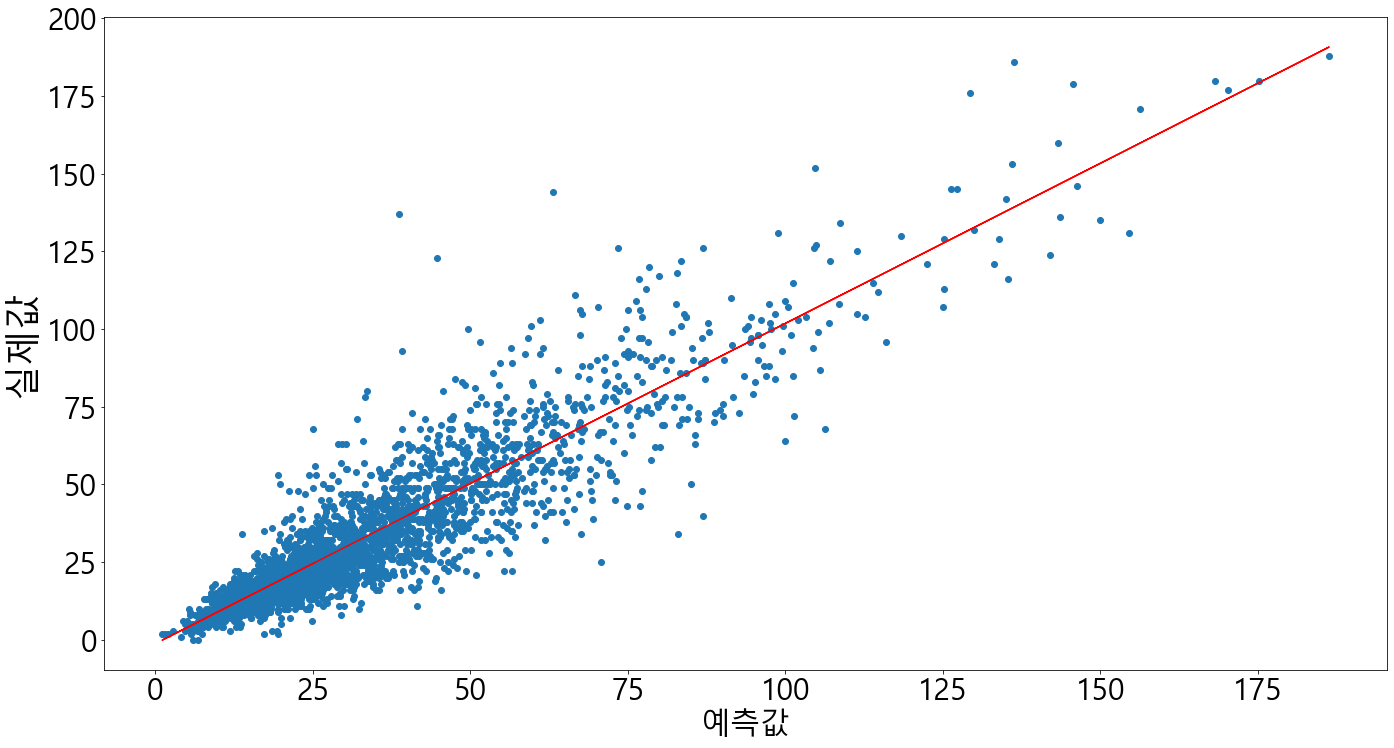

In [38]:
fit = np.polyfit(df_pred['Predicted'], df_pred['Actual'],1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(23,12))
plt.plot(df_pred['Predicted'], df_pred['Actual'],'o')
plt.plot(df_pred['Predicted'], fit_fn(df_pred['Predicted']), 'r')
plt.tick_params(labelsize=30)
plt.xlabel('예측값',size=30)
plt.ylabel('실제값',size=36)

In [9]:
#Rolling pm2.5 window= 24
data = df.copy()
data['pm25_window_24'] = data['pm25'].rolling(window=24).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','weekday'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season","time"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [10]:
# hyper parameter tunning
models = []
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(3,5)]
models +=[XGBRegressor(max_depth= 8,
                       objective='reg:squarederror',
                       min_child_weight=1.111, n_estimator= n, subsample=0.6, random_state =5) for n in [30,50,100,200,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'xgboost.sklearn.XGBRegressor'>
8 <class 'xgboost.sklearn.XGBRegressor'>
9 <class 'xgboost.sklearn.XGBRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
11 <class 'xgboost.sklearn.XGBRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 10.698
RMSE : 10.714


Text(0, 0.5, '실제값')

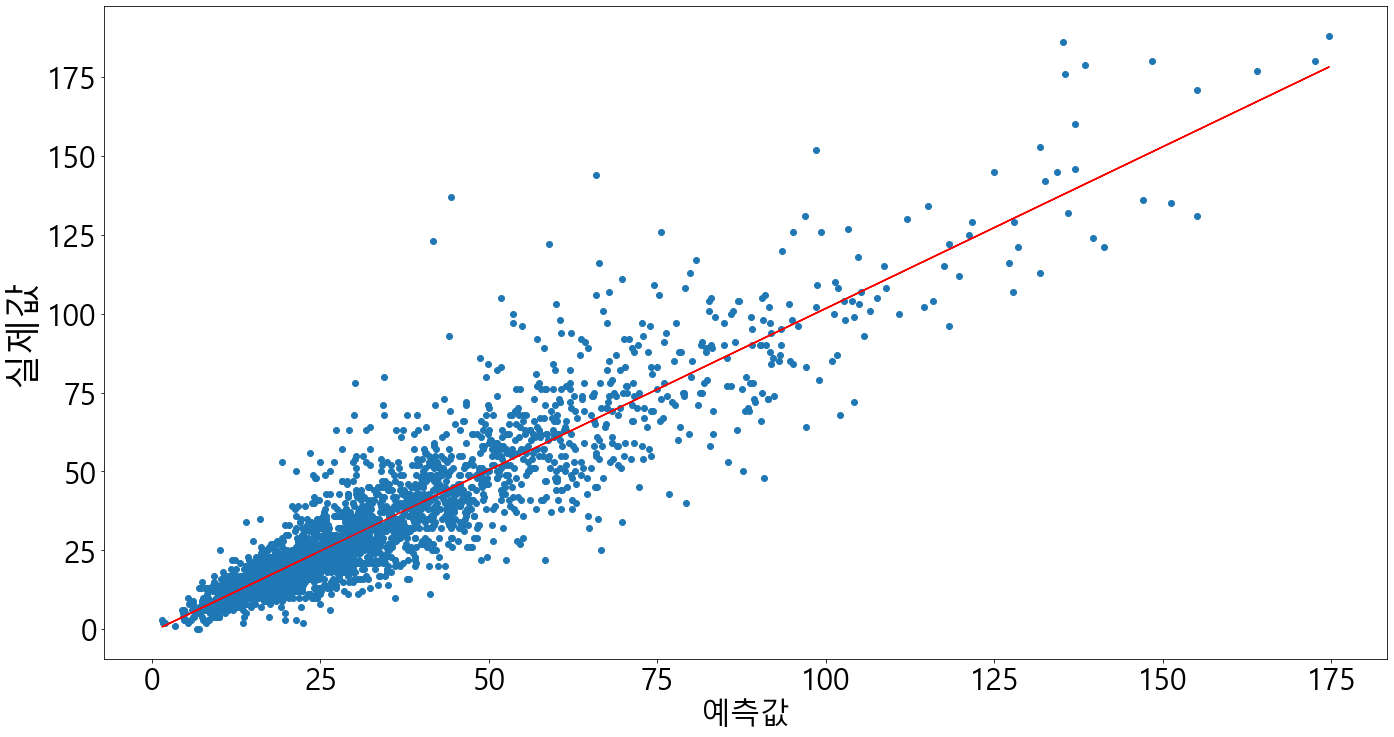

In [11]:
fit = np.polyfit(df_pred['Predicted'], df_pred['Actual'],1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(23,12))
plt.plot(df_pred['Predicted'], df_pred['Actual'],'o')
plt.plot(df_pred['Predicted'], fit_fn(df_pred['Predicted']), 'r')
plt.tick_params(labelsize=30)
plt.xlabel('예측값',size=30)
plt.ylabel('실제값',size=36)

In [12]:
#Rolling pm10, pm2.5 window= 24
data = df.copy()
data['pm10_window_24'] = data['pm10'].rolling(window=24).mean()
data['pm25_window_24'] = data['pm25'].rolling(window=24).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','weekday'], axis=1)
Y = data["pm25"]

# one-hot encoding
# object 변수만 해당
for i in ["season","time"]:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [13]:
# hyper parameter tunning
models = []
models = [RandomForestRegressor(n_estimators=n, random_state =5) for n in [ 30, 50, 100, 200]]
models+=[GradientBoostingRegressor(random_state =5)]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=i, coef0=2.5) for i in range(3,5)]
models +=[XGBRegressor(max_depth= 8,
                       objective='reg:squarederror',
                       min_child_weight=1.111, n_estimator= n, subsample=0.6, random_state =5) for n in [30,50,100,200,500,1000]]

average_modeling(models)

0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
5 <class 'sklearn.kernel_ridge.KernelRidge'>
6 <class 'sklearn.kernel_ridge.KernelRidge'>
7 <class 'xgboost.sklearn.XGBRegressor'>
8 <class 'xgboost.sklearn.XGBRegressor'>
9 <class 'xgboost.sklearn.XGBRegressor'>
10 <class 'xgboost.sklearn.XGBRegressor'>
11 <class 'xgboost.sklearn.XGBRegressor'>
12 <class 'xgboost.sklearn.XGBRegressor'>
RMSE : 10.532
RMSE : 10.601


Text(0, 0.5, '실제값')

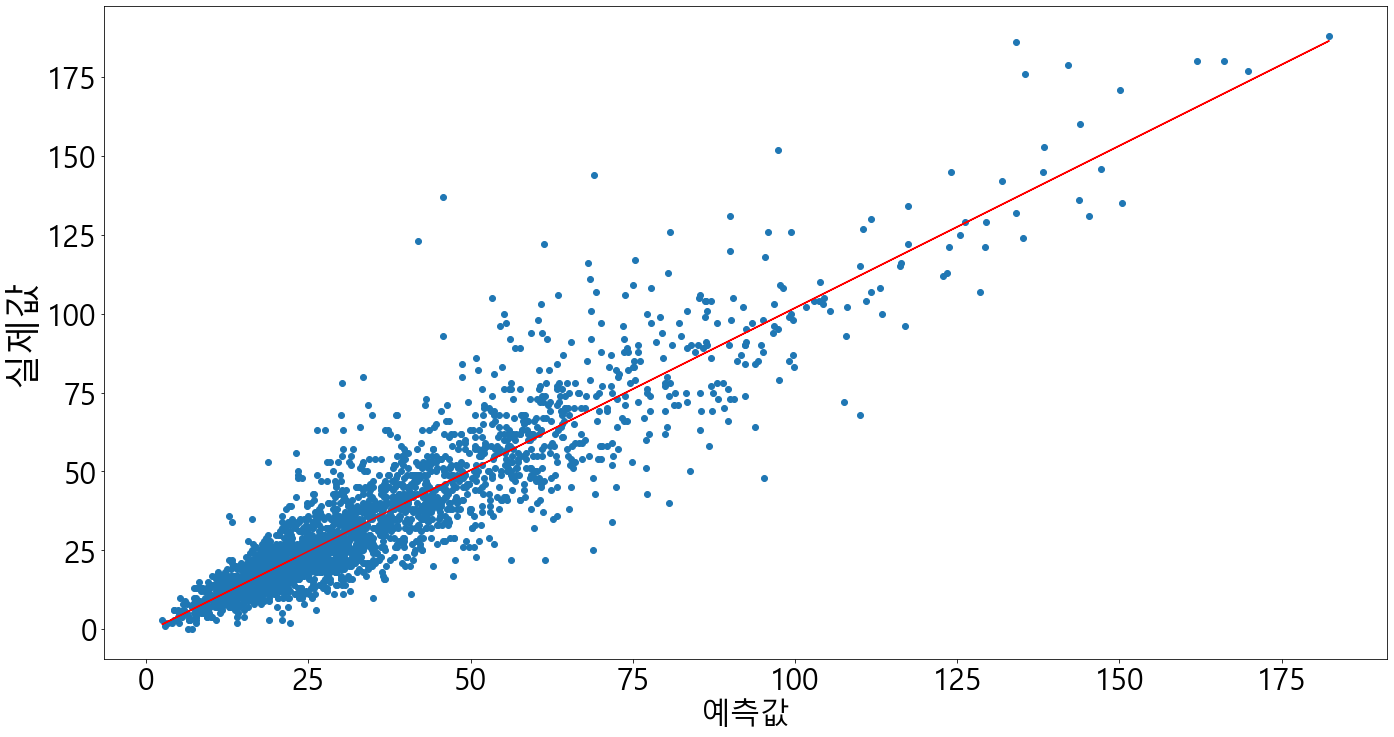

In [14]:
fit = np.polyfit(df_pred['Predicted'], df_pred['Actual'],1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(23,12))
plt.plot(df_pred['Predicted'], df_pred['Actual'],'o')
plt.plot(df_pred['Predicted'], fit_fn(df_pred['Predicted']), 'r')
plt.tick_params(labelsize=30)
plt.xlabel('예측값',size=30)
plt.ylabel('실제값',size=36)

# Window Moving 범주형 데이터 측정

In [2]:
df = pd.read_csv('D:/data/row_sihwa.csv',encoding='CP949')

In [3]:
# preprocessing
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df[['site', 'date', 'so2', 'co', 'o3', 'no2', 'pm10', 'pm25', 'weather',
       'wind_speed', 'wind_direction', 'rain_yn', 'humid']]
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
df.loc[df['weather'] <= -30, 'weather' ] = np.float("nan")
df.isnull().sum()

site                 0
date                 0
so2                566
co                 487
o3                 448
no2                439
pm10               672
pm25              8002
weather            403
wind_speed         351
wind_direction     351
rain_yn            384
humid              333
dtype: int64

In [4]:
## EDA 위한 파생변수 ymd, md, month, season ,weekday, pm categori 추가
def date_split(df) :
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
    df['ymd'] = [d.date() for d in df['date']]
    df['month'] = [d.month for d in df['date']]
    df['time'] = [d.time() for d in df['date']]
    df['time'] = df['time'].apply(lambda x: x.strftime('%H'))
    df['md'] = df['ymd'].apply(lambda x: x.strftime('%m-%d'))
    df['weekday'] =df['date'].apply(lambda x: x.strftime('%A'))
def season(x):
    if '05-31'>= x>='03-01':
        return('봄')
    elif '11-30' >= x >= '09-01':
        return('가을')
    elif '08-31' >=x >= '06-01':
        return('여름')
    else: return('겨울')

def categorical_PM(x):
    if 8>= x>=0:
        return('0')
    elif 15 >= x >= 9 :
        return('1')
    elif 20 >=x >= 16:
        return('2')
    elif 25 >=x >= 21:
        return('3')
    elif 37 >=x >= 26:
        return('4')
    elif 50 >=x >= 38:
        return('5')
    elif 75 >=x >= 51:
        return('6')
    else: return('7') 

In [8]:
# categorical modeling definition

def categorical_modeling(models):
    votingC = VotingClassifier(estimators=[(f'{m}' , m) for m in models], voting='hard')
 
    votingC = votingC.fit(x_train, y_train)

    #예측 진행
    y_pred = votingC.predict(x_test) 

    # ACC, F1-score check
    print("ACC : ", accuracy_score(y_test, y_pred))
    print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

In [5]:
date_split(df)
df = df.dropna()
df['season'] = df['md'].apply(season)
df['PM_categorical'] = df['pm25'].apply(categorical_PM)
df['PM_categorical'] = df['PM_categorical'].astype('category')
df = df[df['site']=='시화산단']
df.drop(['date','site','md','ymd'],axis=1,inplace=True)
df = df.reset_index(drop=True)

In [6]:
#Rolling pm10, pm2.5 window= 24
data = df.copy()
data['pm10_window_24'] = data['pm10'].rolling(window=24).mean()
data['pm25_window_24'] = data['pm25'].rolling(window=24).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','PM_categorical'], axis=1)
Y = data["PM_categorical"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "weekday",'time']:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

In [9]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.5476280834914611
f1-score :  0.5535114968780477


In [18]:
#Rolling pm10, pm2.5 window= 6
data = df.copy()
data['pm10_window_24'] = data['pm10'].rolling(window=6).mean()
data['pm25_window_24'] = data['pm25'].rolling(window=6).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','PM_categorical'], axis=1)
Y = data["PM_categorical"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "weekday",'time']:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

In [19]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.5759757483895415
f1-score :  0.5852071808106069


In [21]:
#check top 10 modeling

for i,m in enumerate(models):
    print(i, m.__class__)
    m.fit(x_train, y_train)
models = sorted(models, key=lambda m: accuracy_score(y_test, m.predict(x_test)),reverse= True)
models

0 <class 'sklearn.ensemble.forest.RandomForestClassifier'>
1 <class 'sklearn.ensemble.forest.RandomForestClassifier'>
2 <class 'sklearn.ensemble.forest.RandomForestClassifier'>
3 <class 'sklearn.ensemble.forest.RandomForestClassifier'>
4 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
5 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
6 <class 'xgboost.sklearn.XGBClassifier'>
7 <class 'xgboost.sklearn.XGBClassifier'>
8 <class 'xgboost.sklearn.XGBClassifier'>
9 <class 'xgboost.sklearn.XGBClassifier'>
10 <class 'lightgbm.sklearn.LGBMClassifier'>
11 <class 'lightgbm.sklearn.LGBMClassifier'>
12 <class 'lightgbm.sklearn.LGBMClassifier'>
13 <class 'lightgbm.sklearn.LGBMClassifier'>


[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=600,
                        n_jobs=None, oob_score=False, random_state=5, verbose=0,
                        warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=5, verbose=0,
                        warm_start=False),
 XGBClas

In [23]:
models = models[0:10]
categorical_modeling(models)

ACC :  0.4893939393939394
f1-score :  0.49387781925641283


In [13]:
xgb_param = {'subsample': 0.3333333333333333, 'n_estimator': 1750, 
             'min_child_weight': 2.928571428571429, 'max_depth': 23, 'learning_rate': 0.06896551724137931}

lgb_param = {'num_leaves': 43, 'n_estimator': 370, 'max_depth': 21, 'learning_rate': 0.10344827586206896, 
             'bagging_fraction': 0.8105263157894737}

In [16]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[XGBClassifier(subsample= 0.3333333333333333, n_estimator= 1750, 
             min_child_weight= 2.928571428571429, max_depth= 23, learning_rate= 0.06896551724137931, random_state =5) ]
models += [LGBMClassifier(num_leaves = 43, n_estimator= 370, max_depth= 21, learning_rate =0.10344827586206896, 
             bagging_fraction= 0.8105263157894737, random_state=5)]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]

categorical_modeling(models)

ACC :  0.4871212121212121
f1-score :  0.49137190788830487


In [ ]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=10, random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

In [20]:
#Rolling pm10, pm2.5 window= 360
data = df.copy()
data['pm10_window_24'] = data['pm10'].rolling(window=360).mean()
data['pm25_window_24'] = data['pm25'].rolling(window=360).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','PM_categorical'], axis=1)
Y = data["PM_categorical"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "weekday",'time']:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

In [21]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.5381619937694704
f1-score :  0.5430236711020411


In [16]:
#Rolling pm10, pm2.5 window= 720
data = df.copy()
data['pm10_window_24'] = data['pm10'].rolling(window=720).mean()
data['pm25_window_24'] = data['pm25'].rolling(window=720).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','PM_categorical'], axis=1)
Y = data["PM_categorical"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "weekday",'time']:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

In [17]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.53125
f1-score :  0.5393645130610237


In [6]:
#Rolling pm2.5 window= 6
data = df.copy()
data['pm25_window_24'] = data['pm25'].rolling(window=6).mean()
# rolling 하며 생긴 na 값 제거
data.dropna(inplace=True)
random.seed(5)

## x, y setting
X = data.drop(["pm25",'pm10','PM_categorical'], axis=1)
Y = data["PM_categorical"]

# one-hot encoding
# object 변수만 해당
for i in ["season", "weekday",'time']:
    X[i] = pd.get_dummies(X[i])
# trian / test split 0.8/ 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

In [7]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.5740810913224706
f1-score :  0.5830367989971448


In [34]:
# add lightGBM
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
models+=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
# models += [RandomForestClassifier(n_estimators=770, min_samples_split=3, max_depth=17,random_state =5)]
models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            random_state=5)for n in [50,100,500,1000]]

categorical_modeling(models)

ACC :  0.5476280834914611
f1-score :  0.5535114968780477


In [32]:
# parameter tunning
models = [RandomForestClassifier(n_estimators=n,random_state =5) for n in [50, 100, 200, 600]]
# models = [RandomForestClassifier(n_estimators=770, min_samples_split=3, max_depth=17,random_state =5)]
models=[GradientBoostingClassifier(n_estimators=n_e, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5) for n_e in [3000, 5000]]
# models+=[XGBClassifier(max_depth=10,n_estimators=n, random_state =5) for n in [50, 100,200,400]]
models+=[XGBClassifier(subsample= 0.3333333333333333, n_estimator= 1750, 
             min_child_weight= 2.928571428571429, max_depth= 23, learning_rate= 0.06896551724137931, random_state =5) ]
# models += [LGBMClassifier( n_estimators=n, max_depth=8, reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             random_state=5)for n in [50,100,500,1000]]
models += [LGBMClassifier(num_leaves= 43, n_estimator= 370, max_depth= 21, learning_rate= 0.10344827586206896, 
             bagging_fraction= 0.8105263157894737)]

categorical_modeling(models)

ACC :  0.5313092979127134
f1-score :  0.5402539389813801


In [29]:
# Random Search CV (XGB)
param = {'max_depth': list(range(4, 25)),
         'learning_rate' : list(np.linspace(0, 1, 30)),
         'gamma' : list(np.linspace(0,10,5)),
         'n_estimator' : list(range(10, 3000, 50)),
         'min_child_weight' : list(np.linspace(1, 15, 20)),
         'subsample' : list(np.linspace(0, 1, 10)),
         'colsample_bytree' : list(np.linspace(0.1,1,15))
}
# Xgboost
model = XGBClassifier(objective='multi:softprob',random_state =5)

xgb_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 5)
xgb_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", xgb_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", xgb_model.best_score_)

best_model = xgb_model.best_estimator_

y_pred = best_model.predict(x_test)
print("ACC : ", accuracy_score(y_test, y_pred))
print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

RandomizedSearchCV 최적의 파라미터 :  {'subsample': 1.0, 'n_estimator': 1510, 'min_child_weight': 15.0, 'max_depth': 7, 'learning_rate': 0.24137931034482757, 'gamma': 0.0, 'colsample_bytree': 0.9357142857142858}
RandomizedSearchCV 최고 정확도 :  0.49221863731258303
ACC :  0.5119544592030361
f1-score :  0.5191013578454415


In [30]:
# Random Search CV (RF)
param = {'max_depth': list(range(4, 25)),
         "n_estimators" : list(range(10, 3000, 30)),
         'min_samples_split' : list(range(2,10))
}
# Xgboost
model = RandomForestClassifier(random_state =5)

rf_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 5)
rf_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", rf_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", rf_model.best_score_)

best_model = rf_model.best_estimator_

y_pred = best_model.predict(x_test)
print("ACC : ", accuracy_score(y_test, y_pred))
print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

RandomizedSearchCV 최적의 파라미터 :  {'n_estimators': 1210, 'min_samples_split': 5, 'max_depth': 24}
RandomizedSearchCV 최고 정확도 :  0.5293224520781932
ACC :  0.5525616698292221
f1-score :  0.5581427632555604


In [31]:
# Random Search CV (LGBM)
param = {'max_depth': list(range(4, 25)),
         'learning_rate' : list(np.linspace(0, 1, 30)),
         'num_leaves' : list(range(1,50)),
         'n_estimator' : list(range(10, 3000, 50)),
         'bagging_fraction' : list(np.linspace(0.001, 1, 10))
}
# LightGBM
model = LGBMClassifier(random_state =5)

lgb_model = RandomizedSearchCV(estimator= model, param_distributions = param, cv = 5)
lgb_model.fit(x_train, y_train)

print("RandomizedSearchCV 최적의 파라미터 : ", lgb_model.best_params_)
print("RandomizedSearchCV 최고 정확도 : ", lgb_model.best_score_)

best_model = lgb_model.best_estimator_

y_pred = best_model.predict(x_test)
print("ACC : ", accuracy_score(y_test, y_pred))
print("f1-score : ", f1_score(y_test, y_pred, average='macro'))

RandomizedSearchCV 최적의 파라미터 :  {'num_leaves': 20, 'n_estimator': 360, 'max_depth': 15, 'learning_rate': 0.5172413793103449, 'bagging_fraction': 0.667}
RandomizedSearchCV 최고 정확도 :  0.49819700132852535
ACC :  0.5203036053130929
f1-score :  0.5327145151630901


In [ ]:
#blending and stacking

